# Supervised Learning

Supervised learning is a machine learning regime in which we receive a set $\{(x_i, y_i)\}_{i=1}^n$ where each $x_i$ is an input example and each $y_i$ is a label. For example, $x_i$ could be a vector containing some measurements about the paw size of an animal, and $y_i$ could be a label indicating the species of the animal. We call this set of examples the training data.

In a supervised learning setup, we want to use the training data to learn a function $f$ that maps from the example space into the label space. Formally we have a example space $\mathcal{X}$ and a label space $\mathcal{Y}$ and each $x_i \in \mathcal{X}$, $y_i \in \mathcal{Y}$. For most setups you can think of $\mathcal{X}$ as $\mathbb{R}^n$ and $\mathcal{Y} \subset \mathbb{N}$. Our formal goal is then to learn a function $f:\mathcal{X} \rightarrow \mathcal{Y}$ that is accurate to the truth.

## Experimental setup

To keep things simple we'll classify points as coming from one of two distributions. Each distribution will be a unit Gaussian with means $\mu_1 = (1,1)$ and $\mu_{-1} = (-1, -1)$. To get examples we will sample from these two distributions. To see why it is useful to discriminate between these two, think about the paw size of domesticated cats versus wild cats, how is each distributed?

The code to sample from these distributions is below

In [1]:
import torch
from helpers import *

def build_data(center_pos, center_neg, std, n):
    center_pos = torch.tensor(center_pos)
    center_neg = torch.tensor(center_neg)
    means_pos = torch.stack([center_pos] *int(n/2)).float()
    means_neg = torch.stack([center_neg] *int(n/2)).float()
    X_pos = torch.normal(mean=means_pos, std=1)
    X_neg = torch.normal(mean=means_neg,std=1)
    labels = torch.cat([torch.ones(int(n/2)), -1*torch.ones(int(n/2))])
    X = torch.cat((X_pos, X_neg), dim=0)
    return X, labels



In [2]:
n = 100
X, labels = build_data((1,1), (-1,-1), 1,n )
labels.shape, X.shape

(torch.Size([100]), torch.Size([100, 2]))

# Problem Visualization

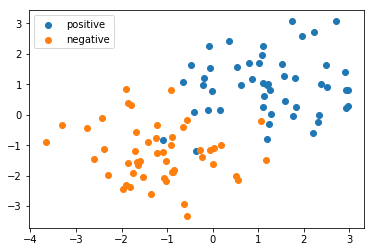

In [3]:
pos_idxs = range(0, int(n/2))
neg_idxs = range(int(n/2), n)
visualize_points(X, pos_idxs, neg_idxs)

# Building two classifiers

## Linear Regression and Maximum Likelihood Estimation

Linear Regression is a method of finding the relationship between a set of input variables and a response variable. In general linear regression is so named for fitting to models of the form:

$$ y = w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$$

In other words, it is called Linear Regression because the input $x_1, \ldots x_n$ is linearly related to the response variable $y$. Given this model, we have a number of potential loss functions. Each loss function is related to a generating distribution $D$. Below is a comparison of two different generating distributions.

##  Normal Likelihood and the MSE Loss
Recall the MSE loss

$$||y - w^Tx||^2$$


If we use the MSE Loss we are saying that we expect $y | w^Tx \sim \mathcal{N}(w^Tx, 1)$. For a classification context this is not exactly correct, because our values are constrained to $[-1,1]$ but the results will be alright.

In [4]:
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
model_MSE = nn.Linear(2,1)
loss = nn.MSELoss()
data = torch.cat((X, labels.unsqueeze(1)),dim=1)
loader = DataLoader(TensorDataset(data), batch_size=1, shuffle=True)
epochs = 15
train(model_MSE, loss, loader, epochs)

In [5]:
weights, bias = [param for param in model_MSE.parameters()]
weights, bias

(Parameter containing:
 tensor([[0.1297, 0.6573]], requires_grad=True), Parameter containing:
 tensor([0.0145], requires_grad=True))

### plot weights for linear regression

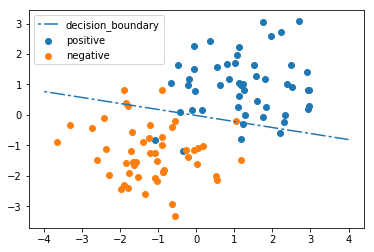

In [6]:
visualize_decision(weights, bias, X)

## Logistic Loss and Bernoulli Likelihood

Next we will use the logistic loss given by $\frac{1}{\ln 2}\ln(1 + e^{-yw^Tx})$. This loss function fits the distribution


$$y|w^Tx \sim Bernoulli\left(\frac{1}{1 + e^{-w^Tx}}\right)$$

Which you will notice is exactly the situation we are in for binary classification.

In [7]:
#first we need a logistic loss target
class LogisticLoss(nn.Module):
    def __init__(self, norm=torch.log(torch.tensor(2.0))):
        """
        Initialize a logistic loss object
        """
        super(LogisticLoss, self).__init__()
        self.norm = norm
        
    def forward(self, pred, target):
        return (self.norm * torch.log(1 + torch.exp(-1*target*pred))).sum()

In [8]:
loss = LogisticLoss()
model_ll = nn.Linear(2,1)
loader = DataLoader(TensorDataset(data), batch_size=1, shuffle=True)
epochs = 15
train(model_ll, loss, loader, epochs)
weights, bias = [param for param in model_ll.parameters()]
weights, bias

(Parameter containing:
 tensor([[1.1332, 1.7031]], requires_grad=True), Parameter containing:
 tensor([0.0769], requires_grad=True))

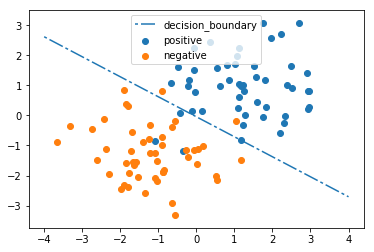

In [9]:
visualize_decision(weights, bias, X)

# Measuring Performance

As you can see, these models each produced quite different decision boundaries. A natural question is, which of these decision boundaries is better? A theoretician may say that the latter of the lines is better, because it was generated using correct assumptions about the generating process. However, we can see this experimentally as well.

In [24]:
n = 1000
X, labels = build_data((1,1), (-1,-1), 1,n )
# we grab our predictions by sign(X) each time
pred_mse = torch.sign(model_MSE(X))
err_mse = (labels != pred_mse.squeeze()).sum().float()/n
pred_ll = torch.sign(model_ll(X))
err_ll = (labels != pred_ll.squeeze()).sum().float()/n
print(f"MSE Error Rate: {err_mse}")
print(f"Logistic Loss Error Rate: {err_ll}")

MSE Error Rate: 0.12999999523162842
Logistic Loss Error Rate: 0.0860000029206276


# Higher Dimensional Experiments